# Detección de anomalías

La detección de anomalías (*anomaly detection*, AD) es una tarea de aprendizaje automático que consiste en detectar *outliers* o datos fuera de rango.

*An outlier is an observation in a data set which appears to be inconsistent with the remainder of that set of data.*
Johnson 1992

*An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.*
  Outlier/Anomaly
Hawkins 1980

## Tipos de entornos en los que se produce la detección de anomalías

- AD supervisada

    - Las etiquetas están disponibles, tanto para casos normales como para casos anómalos.
    - En cierto modo, similar a minería de clases poco comunes o clasificación no balanceada.
    
    
    
- AD Semi-supervisada (detección de novedades, *Novelty Detection*)

    - Durante el entrenamiento, solo tenemos datos normales.
    - El algoritmo aprende únicamente usando los datos normales.
    
    
    
- AD no supervisada (detección de outliers, *Outlier Detection*)

    - No hay etiquetas y el conjunto de entrenamiento tiene datos normales y datos anómalos.
    - Asunción: los datos anómalos son poco frecuentes.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Vamos a familiarizarnos con la detección de anomalías no supervisada. Para visualizar la salida de los distintos algoritmos, vamos a considerar un dataset bidimensional que consiste en una mixtura de Gaussianas.

### Generando el dataset

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_features=2, centers=3, n_samples=500,
                  random_state=666)

In [3]:
X.shape

(500, 2)

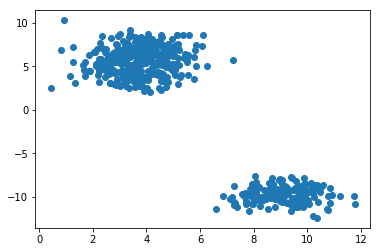

In [4]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## Detección de anomalías con estimación de densidad

In [5]:
from sklearn.neighbors.kde import KernelDensity

# Estimador de densidad Gaussiano
kde = KernelDensity(kernel='gaussian')
kde = kde.fit(X)
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [6]:
kde_X = kde.score_samples(X)
print(kde_X.shape)  # nos proporciona la verosimilitud de los datos. Cuanto más baja, más anómalo

(500,)


In [7]:
from scipy.stats.mstats import mquantiles
alpha_set = 0.95
tau_kde = mquantiles(kde_X, 1. - alpha_set)

In [8]:
n_samples, n_features = X.shape
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0) - 1.
X_range[:, 1] = np.max(X, axis=0) + 1.

h = 0.1  # Tamaño de paso de la rejilla
x_min, x_max = X_range[0]
y_min, y_max = X_range[1]
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

No handles with labels found to put in legend.


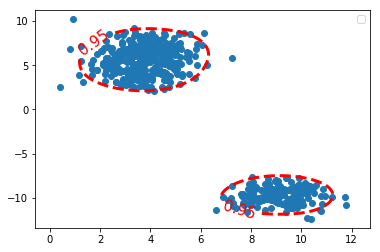

In [9]:
Z_kde = kde.score_samples(grid)
Z_kde = Z_kde.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_kde, levels=tau_kde, colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_kde[0]: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.legend()
plt.show()

## One-Class SVM

El problema de usar la estimación de densidad es que es ineficiente cuando la dimensionalidad de los datos es demasiado alta. El algoritmo *one-class SVM* si que puede utilizarse en estos casos.

In [10]:
from sklearn.svm import OneClassSVM

In [11]:
nu = 0.05  # Resultados teóricos dicen que hay un 5% de datos anómalos
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu)
ocsvm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [12]:
X_outliers = X[ocsvm.predict(X) == -1]

No handles with labels found to put in legend.


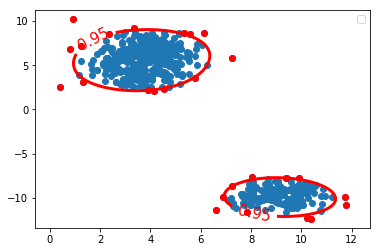

In [13]:
Z_ocsvm = ocsvm.decision_function(grid)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_ocsvm, levels=[0], colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={0: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red')
plt.legend()
plt.show()

### Vectores soporte o outliers

En el one-class SVM, no todos los vectores soporte son outliers:

In [14]:
X_SV = X[ocsvm.support_]
n_SV = len(X_SV)
n_outliers = len(X_outliers)

print('{0:.2f} <= {1:.2f} <= {2:.2f}?'.format(1./n_samples*n_outliers, nu, 1./n_samples*n_SV))

0.05 <= 0.05 <= 0.06?


Solo los vectores soporte sirven a la hora de calcular la función de decisión del One-Class SVM.

Ahora vamos a representar la función de decisión del One-Class SVM como hicimos con la densidad y vamos a marcar los vectores soporte.

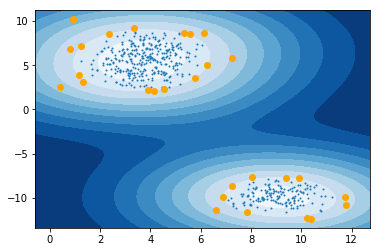

In [15]:
plt.figure()
plt.contourf(xx, yy, Z_ocsvm, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_SV[:, 0], X_SV[:, 1], color='orange')
plt.show()

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      **Cambia** el parámetro `gamma` y comprueba como afecta la función de decisión.
      </li>
    </ul>
</div>

## *Isolation Forest*

El algoritmo *Isolation Forest* es un algoritmo de AD basado en árboles. Construye un determinado número de árboles aleatorios y su idea principal es que si un ejemplo es una anomalía, entonces debería aparecer aislado en la hoja de un árbol tras algunas particiones. El *Isolation Forest* deriva una puntuación de anormalidad basada en la profundidad del árbol en la cuál términos los ejemplos anómalos.

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
iforest = IsolationForest(n_estimators=300, contamination=0.10)
iforest = iforest.fit(X)

No handles with labels found to put in legend.


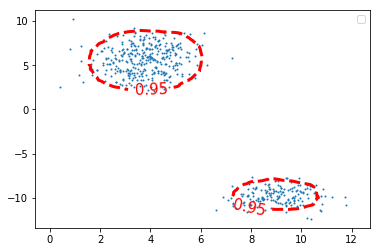

In [18]:
Z_iforest = iforest.decision_function(grid)
Z_iforest = Z_iforest.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_iforest,
                  levels=[iforest.threshold_],
                  colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15,
           fmt={iforest.threshold_: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.legend()
plt.show()

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      Ilustra gráficamente la influencia del número de árboles en la suavidad de la función de decisión
      </li>
    </ul>
</div>

# Aplicación al dataset de dígitos

Ahora vamos a aplicar el ``IsolationForest`` para intentar localizar dígitos que han sido escritos de modo poco convencional.

In [19]:
from sklearn import datasets
digits = datasets.load_digits()

La base de datos de dígitos consiste en imágenes de 8x8 valores de gris.

In [20]:
images = digits.images
labels = digits.target
images.shape

(1797, 8, 8)

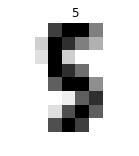

In [21]:
i = 102

plt.figure(figsize=(2, 2))
plt.title('{0}'.format(labels[i]))
plt.axis('off')
plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

Para usar las imágenes como patrones de entrenamiento, tenemos que pasarlas a vector:

In [22]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [23]:
data.shape

(1797, 64)

In [24]:
X = data
y = digits.target

In [25]:
X.shape

(1797, 64)

Vamos a centrarnos en el dígito 5.

In [26]:
X_5 = X[y == 5]

In [27]:
X_5.shape

(182, 64)

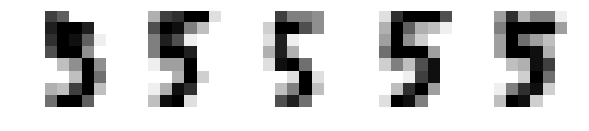

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for ax, x in zip(axes, X_5[:5]):
    img = x.reshape(8, 8)
    ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

Vamos a usar ``IsolationForest`` para encontrar el 5% de imágenes más anómalas y representarlas:

In [29]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=0.05)
iforest = iforest.fit(X_5)

Sacamos el grado de anormalidad utilizando `iforest.decision_function`. Cuanto más bajo, más anómalo.

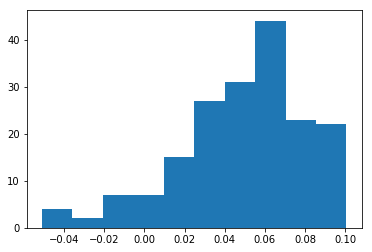

In [30]:
iforest_X = iforest.decision_function(X_5)
plt.hist(iforest_X);

Dibujemos los 10 ejemplos más "normales" (*inliers*):

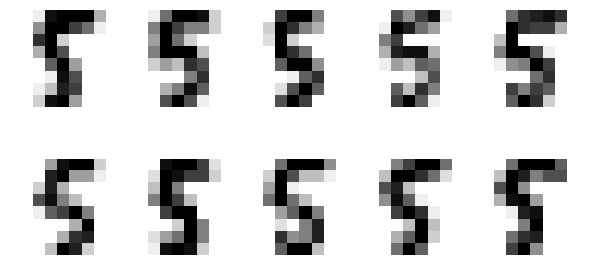

In [31]:
X_strong_inliers = X_5[np.argsort(iforest_X)[-10:]]

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in zip(range(len(X_strong_inliers)), axes.ravel()):
    ax.imshow(X_strong_inliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

Ahora vamos a dibujar los *outliers*:

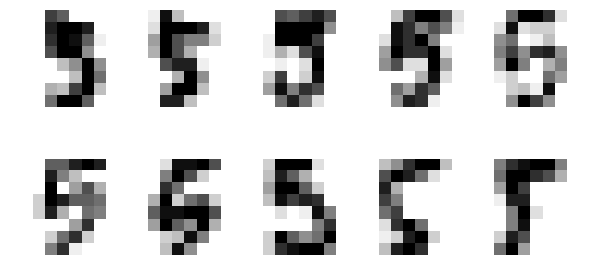

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

X_outliers = X_5[iforest.predict(X_5) == -1]

for i, ax in zip(range(len(X_outliers)), axes.ravel()):
    ax.imshow(X_outliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      Haz lo mismo pero para los dígitos 9 y 7.
      </li>
    </ul>
</div>